# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt

import discretize
from simpeg.potential_fields.gravity import Simulation3DIntegral, Survey, SourceField, Point
from simpeg.maps import IdentityMap
from simpeg.utils import model_builder, depth_weighting

from inversion_ideas import (
    DataMisfit, TikhonovZero, Inversion, ConjugateGradient, create_inversion
)

from gravity import GravitySimulation

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200]) # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(
    coordinates,
    prisms,
    densities,
    field="g_z"
)
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


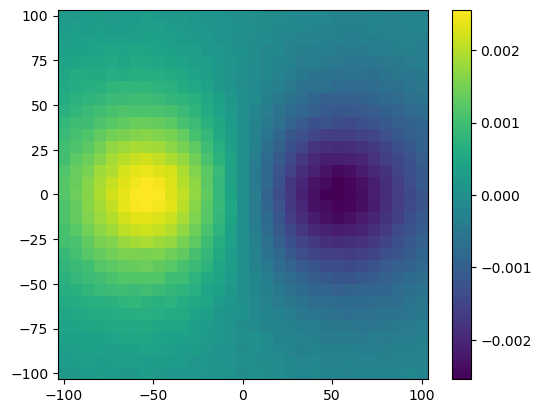

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f5df1c2cf50>,)

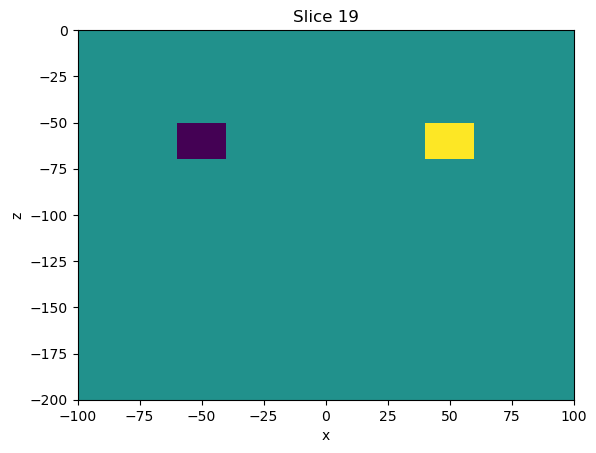

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

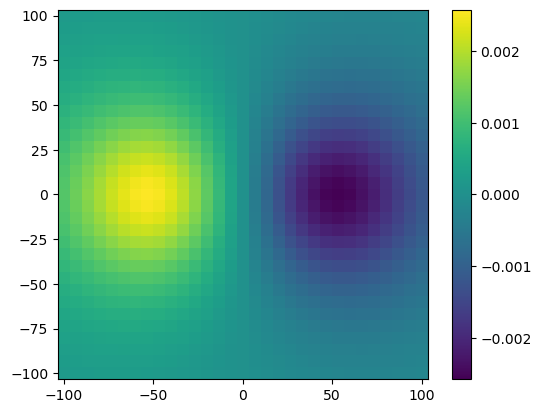

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Define (simple) inversion using the new framework

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = GravitySimulation(simulation_simpeg)

In [15]:
dpred = simulation(model)

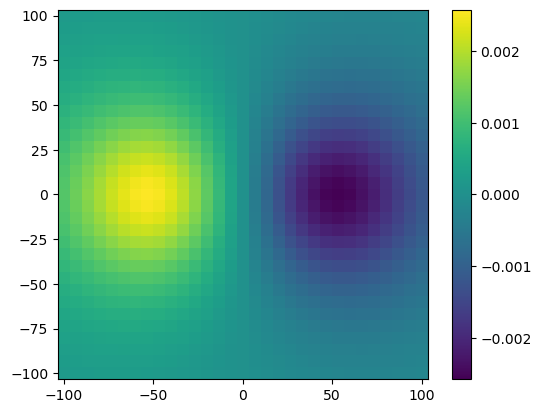

In [16]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [17]:
simulation.jacobian(model)

<961x64000 _CustomLinearOperator with dtype=float64>

In [18]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = DataMisfit(gz.ravel(), uncertainties, simulation)

In [19]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
smallness = TikhonovZero(
    n_params=simulation.n_params, weights=volume_weights * depth_weights
)

In [20]:
phi = data_misfit + 1e2 * smallness

In [21]:
minimizer = ConjugateGradient()

In [22]:
initial_model = np.zeros(simulation.n_params)
inverted_model = minimizer(phi, initial_model)

In [23]:
inverted_model

array([-0.00016457, -0.00016604, -0.00016616, ..., -0.00027763,
        0.0003595 , -0.00030917], shape=(64000,))

(<matplotlib.collections.QuadMesh at 0x7f5df1ae6d50>,)

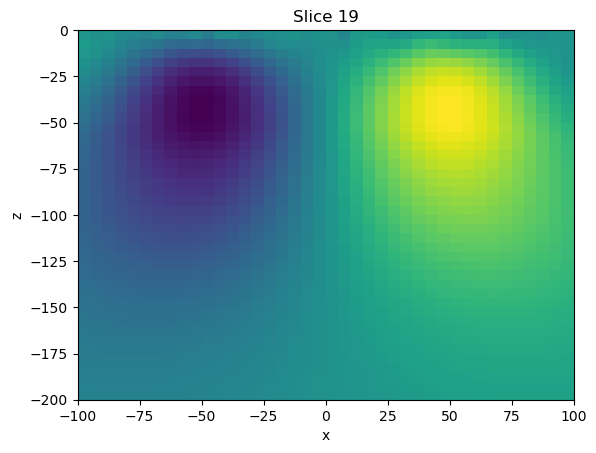

In [24]:
mesh.plot_slice(inverted_model, normal="Y", slice_loc=0)

## Run inversion with beta cooling

In [25]:
inversion = create_inversion(
    data_misfit,
    smallness,
    starting_beta=1e4,
    initial_model=initial_model,
    optimizer=minimizer,
    cache_models=True,
)

In [26]:
inverted_model = inversion.run()

Output()

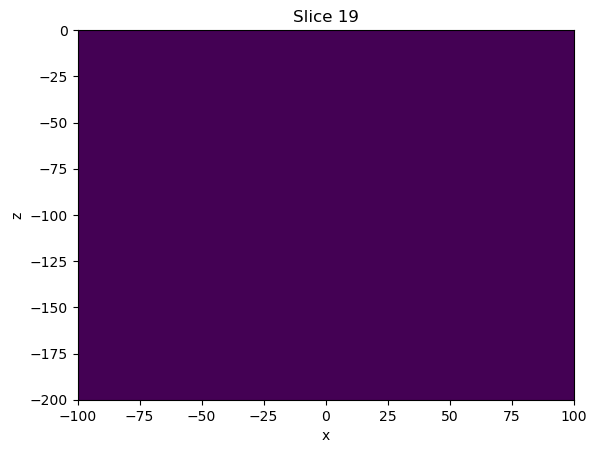

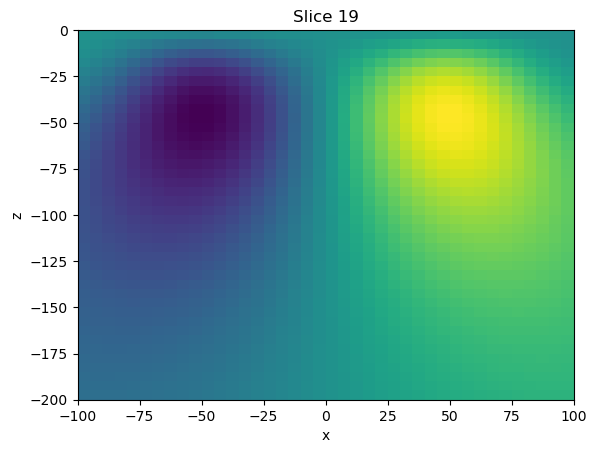

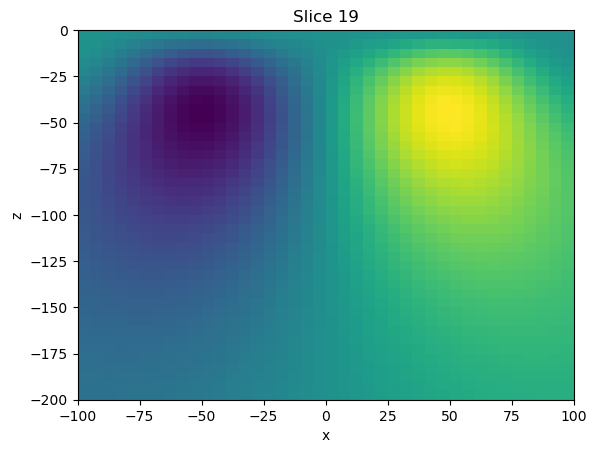

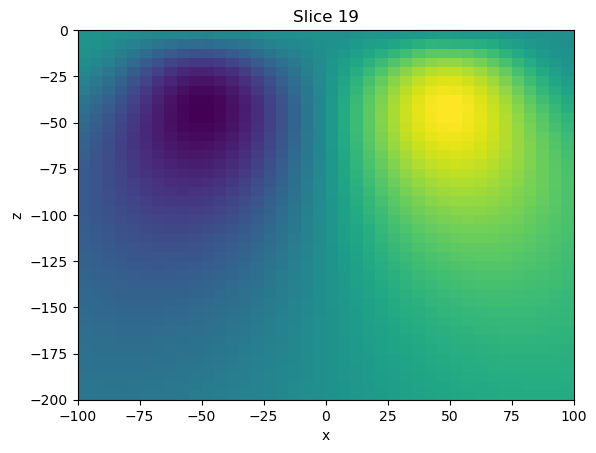

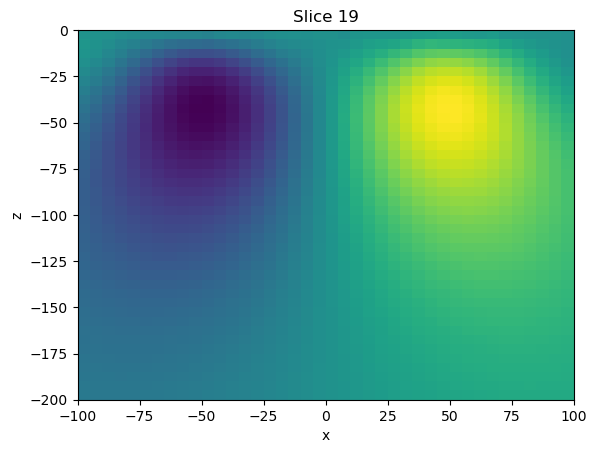

In [28]:
for model in inversion.models:
    mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.show()